In [1]:
import torch
import json

from gcd_data_manipulation import ClusterDataset
from gcd_data_manipulation import prepare_data

# Load data

In [2]:
job_id = 6318371744 # test dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open('columns_selection.json') as f:
    columns_selection = json.load(f)

columns_to_consider = columns_selection['GWT_efficiency_1']

preprocessed_data = prepare_data(f'../data/task-usage_job-ID-{job_id}_total.csv', columns_to_consider, targets=[0], sliding_window=1, aggr_type='mean')


preprocessed_data_2 = prepare_data(f'../data/task-usage_job-ID-{job_id}_total.csv', columns_to_consider, targets=[3, 6, 12], sliding_window=12, aggr_type='mean')

# TODO change parameters to include testset
test_data = ClusterDataset(preprocessed_data, num_targets=1, training=True, split_percentage=1)
test_data.values.to(device)

test_data_2 = ClusterDataset(preprocessed_data_2, num_targets=3, training=True, split_percentage=1)
test_data_2.values.to(device)

tensor([[4.2940e-01, 6.0858e-01, 6.4355e-01,  ..., 9.8716e-04, 0.0000e+00,
         9.8818e-01],
        [4.2940e-01, 6.0858e-01, 6.4355e-01,  ..., 2.0722e-01, 4.6658e-01,
         9.8818e-01],
        [4.2940e-01, 6.0858e-01, 6.4355e-01,  ..., 7.8092e-01, 3.1827e-01,
         9.8754e-01],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0120e-03, 1.0118e-03,
         1.0094e-03],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0132e-03, 1.0094e-03,
         1.0069e-03],
        [1.0000e+00, 9.9865e-01, 1.0000e+00,  ..., 1.0083e-03, 1.0082e-03,
         1.0118e-03]], device='cuda:0')

# Test Model

## Load Model

In [3]:
from shared_workspace_module import SharedWorkspaceModule
import torch.nn as nn

checkpoint = torch.load('../models/gwt_models/gwt_model_exp_01.pth')

args = checkpoint['model_args']
print(f'last epoch: {checkpoint["epoch"]}')
print(f'last loss: {checkpoint["loss"]}')

model = SharedWorkspaceModule(
    h_dim=args.h_dim,
    ffn_dim=args.ffn_dim,
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    dropout=args.dropout,
    shared_memory_attention=args.shared_memory_attention,
    share_vanilla_parameters=args.share_vanilla_parameters,
    use_topk=args.use_topk,
    topk=args.topk,
    mem_slots=args.mem_slots,
    num_targets=1
).cuda()

model.load_state_dict(checkpoint['state_dict'])

# get same inference every time
model.eval()

last epoch: 200
last loss: 0.04323553281453551
transformer embed_dim 64
functional? False
total heads 4
head dim 16
use topk?True
topk:3
MEM SLOTS:4
Null attention:False
USING SHARED MEMORY ATTENTION +++++++++
Using gate style unit
query:8320
key:8320
value:4160
attention_mlp:4160
layernorm1:128
layernorm2:128
input_projector:4160
input projector:64
input_gate_projector:27584
memory_gate_projector:33280
relational volatie!!!


SharedWorkspaceModule(
  (transformer): TransformerEncoder(
    (enc): TransformerEncoderLayerVanilla(
      (self_attn): MultiheadAttention(
        (dropout_module): FairseqDropout()
        (relational_memory): RelationalMemory(
          (query_proj): Linear(in_features=64, out_features=128, bias=True)
          (key_proj): Linear(in_features=64, out_features=128, bias=True)
          (value_proj): Linear(in_features=64, out_features=64, bias=True)
          (attention_mlp): ModuleList(
            (0): Linear(in_features=64, out_features=64, bias=True)
          )
          (attended_memory_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attended_memory_layernorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (input_projector): Linear(in_features=64, out_features=64, bias=True)
          (input_gate_projector): RepeatLinear(
            (pe): PositionEncoder()
            (linear): Linear(in_features=64, out_features=128, bias=True)
 

In [4]:
checkpoint_2 = torch.load('../models/gwt_models/gwt_model_exp_02.pth')

args_2 = checkpoint_2['model_args']
print(f'last epoch: {checkpoint_2["epoch"]}')
print(f'last loss: {checkpoint_2["loss"]}')

model_2 = SharedWorkspaceModule(
    h_dim=args_2.h_dim,
    ffn_dim=args_2.ffn_dim,
    num_layers=args_2.num_layers,
    num_heads=args_2.num_heads,
    dropout=args_2.dropout,
    shared_memory_attention=args_2.shared_memory_attention,
    share_vanilla_parameters=args_2.share_vanilla_parameters,
    use_topk=args_2.use_topk,
    topk=args_2.topk,
    mem_slots=args_2.mem_slots,
    num_targets=3
).cuda()

model_2.load_state_dict(checkpoint_2['state_dict'])

# get same inference every time
model_2.eval()

last epoch: 250
last loss: 0.15692013532750285
transformer embed_dim 64
functional? False
total heads 4
head dim 16
use topk?True
topk:3
MEM SLOTS:4
Null attention:False
USING SHARED MEMORY ATTENTION +++++++++
Using gate style unit
query:8320
key:8320
value:4160
attention_mlp:4160
layernorm1:128
layernorm2:128
input_projector:4160
input projector:64
input_gate_projector:27584
memory_gate_projector:33280
relational volatie!!!


SharedWorkspaceModule(
  (transformer): TransformerEncoder(
    (enc): TransformerEncoderLayerVanilla(
      (self_attn): MultiheadAttention(
        (dropout_module): FairseqDropout()
        (relational_memory): RelationalMemory(
          (query_proj): Linear(in_features=64, out_features=128, bias=True)
          (key_proj): Linear(in_features=64, out_features=128, bias=True)
          (value_proj): Linear(in_features=64, out_features=64, bias=True)
          (attention_mlp): ModuleList(
            (0): Linear(in_features=64, out_features=64, bias=True)
          )
          (attended_memory_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attended_memory_layernorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (input_projector): Linear(in_features=64, out_features=64, bias=True)
          (input_gate_projector): RepeatLinear(
            (pe): PositionEncoder()
            (linear): Linear(in_features=64, out_features=128, bias=True)
 

## Testing the model

In [5]:
from torch.utils.data import DataLoader
from collections import defaultdict

In [6]:
test_loader = DataLoader(test_data, batch_size=64) # TODO experiment with batch_size

criterion = nn.L1Loss(reduction='sum').cuda()

result = defaultdict(list)

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        targets = targets.reshape((targets.shape[0], 1))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss = loss.item() / targets.shape[0]

        result['loss'].append(test_loss)

        for pred in outputs:
            result['predicted_value'].append(pred.to('cpu').numpy())

        for act in targets:
            result['actual_value'].append(act.to('cpu').numpy())


d:\uni\bachelorarbeit\repo\polaris-ai\venv\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([56, 16, 64])
tensor([[-8.1728],
        [-9.6943],
        [-9.6974],
        [-9.6974],
        [-9.6974],
        [-9.3977],
        [-5.6827],
        [-9.6939],
        [-8.5538],
        [-9.6978],
        [-9.2747],
        [-3.8322],
        [-3.8381],
        [-3.8263],
        [-3.8263],
        [-3.8322],
        [-3.8440],
        [-9.6978],
        [-9.6958],
        [-9.6959],
        [-9.6973],
        [-9.6973],
        [-9.6973],
        [-9.6973],
        [-9.6973],
        [-9.5833],
        [-8.4526],
        [-3.7801],
        [-3.7919],
        [-3.7801],
        [-3.7801],
        [-3.7801],
        [-3.7801],
        [-3.7801],
        [-9.6978],
        [-9.6955],
        [-9.6880],
        [-9.6975],
        [-9.6975],
        [-9.6974],
        [-9.6974],
        [-9.6974],
        [-9.6975],
        [-9.6975],
        [-9.6974],
        [-9.6974],
        [-9.6973],
        [-9.6973],
        [-9.6973],
        [-9.6973],
        [-9.6973],
      

In [7]:
test_loader_2 = DataLoader(test_data_2, batch_size=64) # TODO experiment with batch_size

criterion_2 = nn.L1Loss(reduction='sum').cuda()

result_2 = defaultdict(list)

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader_2):
        # targets = targets.reshape((targets.shape[0], 1))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_2(inputs)
        loss = criterion_2(outputs, targets)

        # print(targets.shape)
        # print(outputs.shape)
        test_loss = loss.item() / targets.shape[0]

        result_2['loss'].append(test_loss)

        for pred in outputs:
            result_2['predicted_value'].append(pred.to('cpu').numpy())

        for act in targets:
            result_2['actual_value'].append(act.to('cpu').numpy())

torch.Size([45, 192, 64])
tensor([[0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.3457, 0.3582, 0.3615],
        [0.0864, 0.0852, 0.0943],
        [0.0861, 0.0849, 0.0940],
        [0.0861, 0.0849, 0.0940],
        [0.0861, 0.0849, 0.0940],
        [0.1167, 0.1171, 0.1255],
        [0.4963, 0.5167, 0.5168],
        [0.0864, 0.0852, 0.0943],
        [0.2029, 0.2079, 0.2144],
        [0.0860, 0.0848, 0.0939],
        [0.1293, 0.1303, 0.1385],
        [0.6854, 0.7158, 0.7117],
        [0.6848, 0.7152, 0.7110],
        [0.6860, 0.7164, 0.7123],
        [0.6860, 0.7164, 0.7123],
        [0.6854, 0.7158, 0.7117],
        [0.6842, 0.7145, 0.7104],
        [0.0860, 0.084

# Plot result

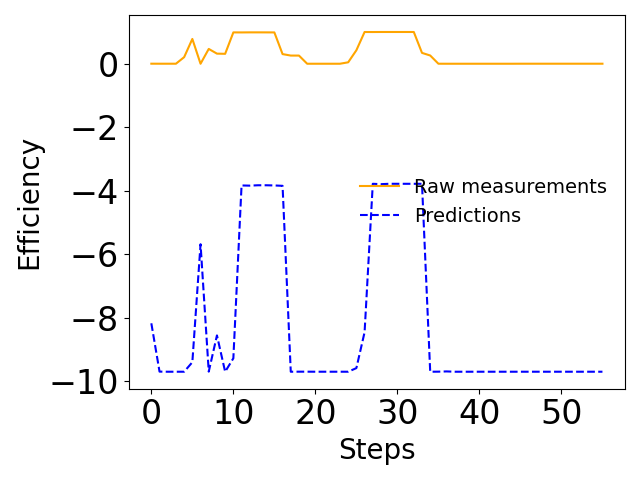

In [8]:
# print(result['predicted_value'])

from matplotlib import pyplot

%matplotlib widget

pyplot.clf()
pyplot.plot(result['actual_value'], '-', color='orange', label='Raw measurements')
pyplot.plot(result['predicted_value'], '--', color='blue', label='Predictions')
pyplot.xlabel('Steps', fontsize=20)
pyplot.ylabel('Efficiency', fontsize=20)
pyplot.xticks(fontsize=24)
pyplot.yticks(fontsize=24)
pyplot.legend(fontsize=14, frameon=False)
pyplot.tight_layout()
# prediction_out_figure = f'../experiments_result/figures_GWT/gcd_{job_id}_pred.png' # TODO

In [9]:
print([x[0] for x in result_2['actual_value'][10:20]])

[0.98817986, 0.9875379, 0.986254, 0.30378333, 0.25753105, 0.25710288, 0.00022425223, 0.0002362919, 0.00022772816, 0.00023120409]


In [10]:
print(result_2['predicted_value'][:10])

[array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32), array([0.34567103, 0.35817802, 0.3615462 ], dtype=float32)]


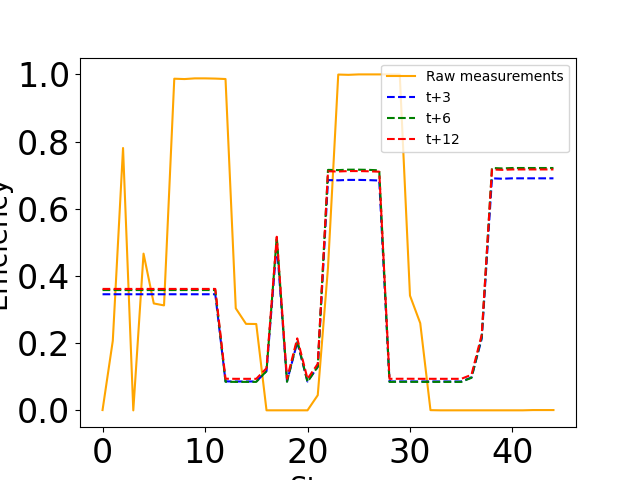

In [11]:
%matplotlib widget

pyplot.clf()
pyplot.plot([x[0] for x in result_2['actual_value']], '-', color='orange', label='Raw measurements')
pyplot.plot([x[0] for x in result_2['predicted_value']], '--', color='blue', label='t+3')
pyplot.plot([x[1] for x in result_2['predicted_value']], '--', color='green', label='t+6')
pyplot.plot([x[2] for x in result_2['predicted_value']], '--', color='red', label='t+12')
pyplot.xlabel('Steps', fontsize=20)
pyplot.ylabel('Efficiency', fontsize=20)
pyplot.xticks(fontsize=24)
pyplot.yticks(fontsize=24)
pyplot.legend(fontsize=14, frameon=False)
pyplot.legend()
# pyplot.savefig('../experiments_result/figures_GWT/manual_saves/exp_02_no_sigmoid_t3_6_12.png')